In [1]:
import tensorflow as tf
from configuration import *
from dataset_utils import create_paired_s2s_image_loader as create_image_loader
from dataset_utils import create_augmentation_with_prob, normalize_two as normalize

train_dataset = tf.data.Dataset.range(TRAIN_SIZE).shuffle(TRAIN_SIZE)
f2r_train_dataset = train_dataset.map(create_image_loader(2, 3, TRAIN_SIZES, "train"), num_parallel_calls=tf.data.AUTOTUNE)
f2r_train_dataset = f2r_train_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
f2r_train_dataset = f2r_train_dataset.batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.range(TEST_SIZE).shuffle(TEST_SIZE)
f2r_test_dataset = test_dataset.map(create_image_loader(2, 3, TEST_SIZES, "test"), num_parallel_calls=tf.data.AUTOTUNE)
f2r_test_dataset = f2r_test_dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
f2r_test_dataset = f2r_test_dataset.batch(BATCH_SIZE)

D:\Projetos 2\pixel-sides\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
import os
from scipy.spatial import KDTree
from skimage.io import imread
from pix2pix_model import Pix2PixModel, Pix2PixIndexedModel

def palette_transform(image, palette):
    palette_tree = KDTree(palette)
    _, indices = palette_tree.query(image)

    result = palette[indices]
    return result

models = [
    Pix2PixModel.build(f2r_train_dataset, f2r_test_dataset, "baseline-l1100-correctgenloss-noaug", "histogram", "patch", "unet", lambda_l1=100., lambda_histogram=0.),
    Pix2PixModel.build(f2r_train_dataset, f2r_test_dataset, "baseline-l1100-correctgenloss", "histogram", "patch", "unet", lambda_l1=100., lambda_histogram=0.),
    # Pix2PixIndexedModel(None, None, "resnet-seg0.01-l10-sortbygray", "indexed", "patch", "unet", lambda_l1=0., lambda_segmentation=0.01, lambda_histogram=0.),
    Pix2PixModel.build(f2r_train_dataset, f2r_test_dataset, "l130-histo1", "histogram", "patch", "unet", lambda_l1=30., lambda_histogram=1.),
]

[m.load_generator() for m in models]

Generator: unet-gen with 29,307,844 parameters
Discriminator: patch-disc with 9,217 parameters
Mode gan with binary_crossentropy loss
Generator: unet-gen with 29,307,844 parameters
Discriminator: patch-disc with 9,217 parameters
Mode gan with binary_crossentropy loss
Generator: unet-gen with 29,307,844 parameters
Discriminator: patch-disc with 9,217 parameters
Mode gan with binary_crossentropy loss


[None, None, None]

Showing images from model index 0


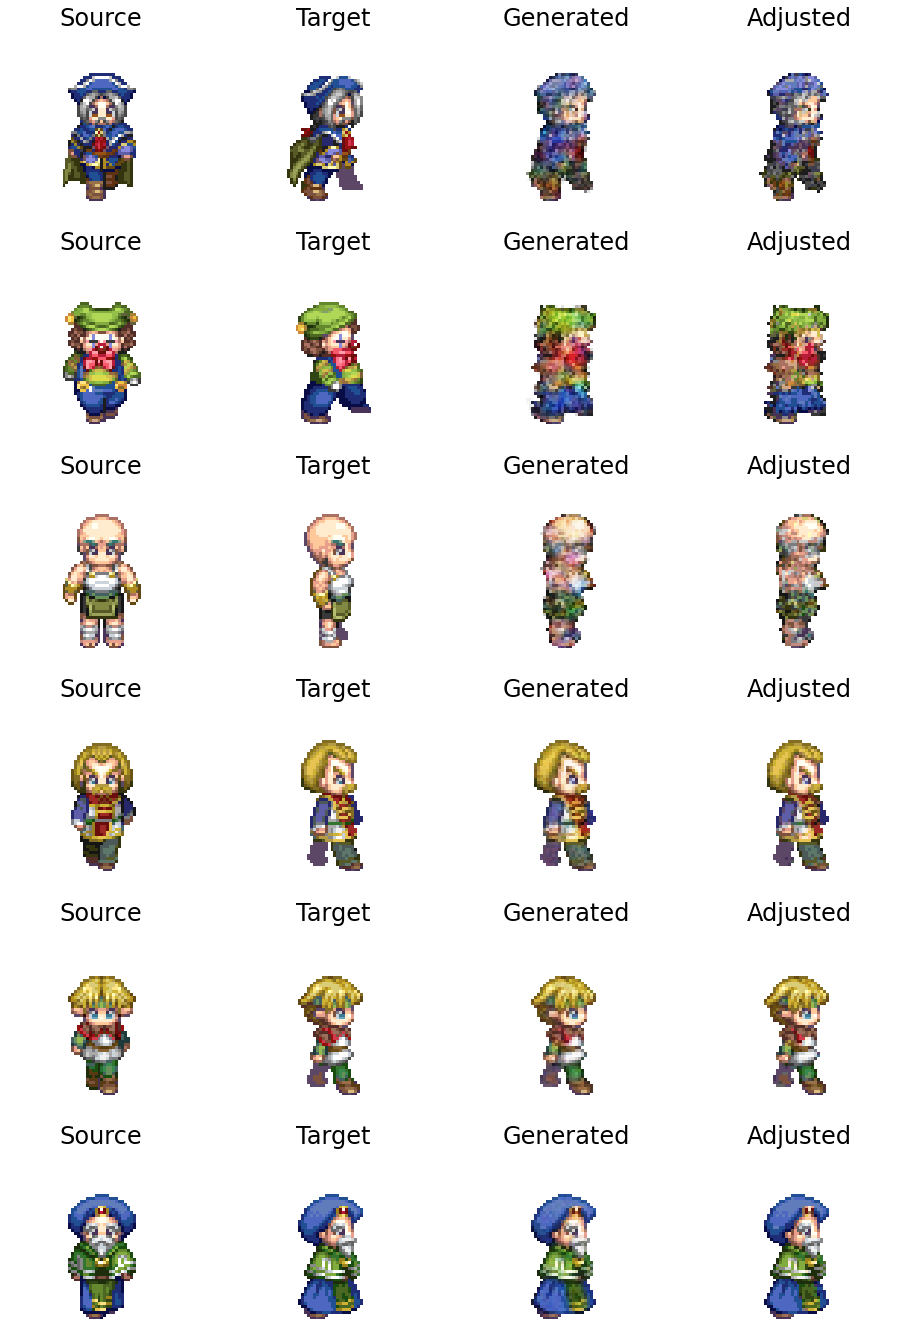

Showing images from model index 1


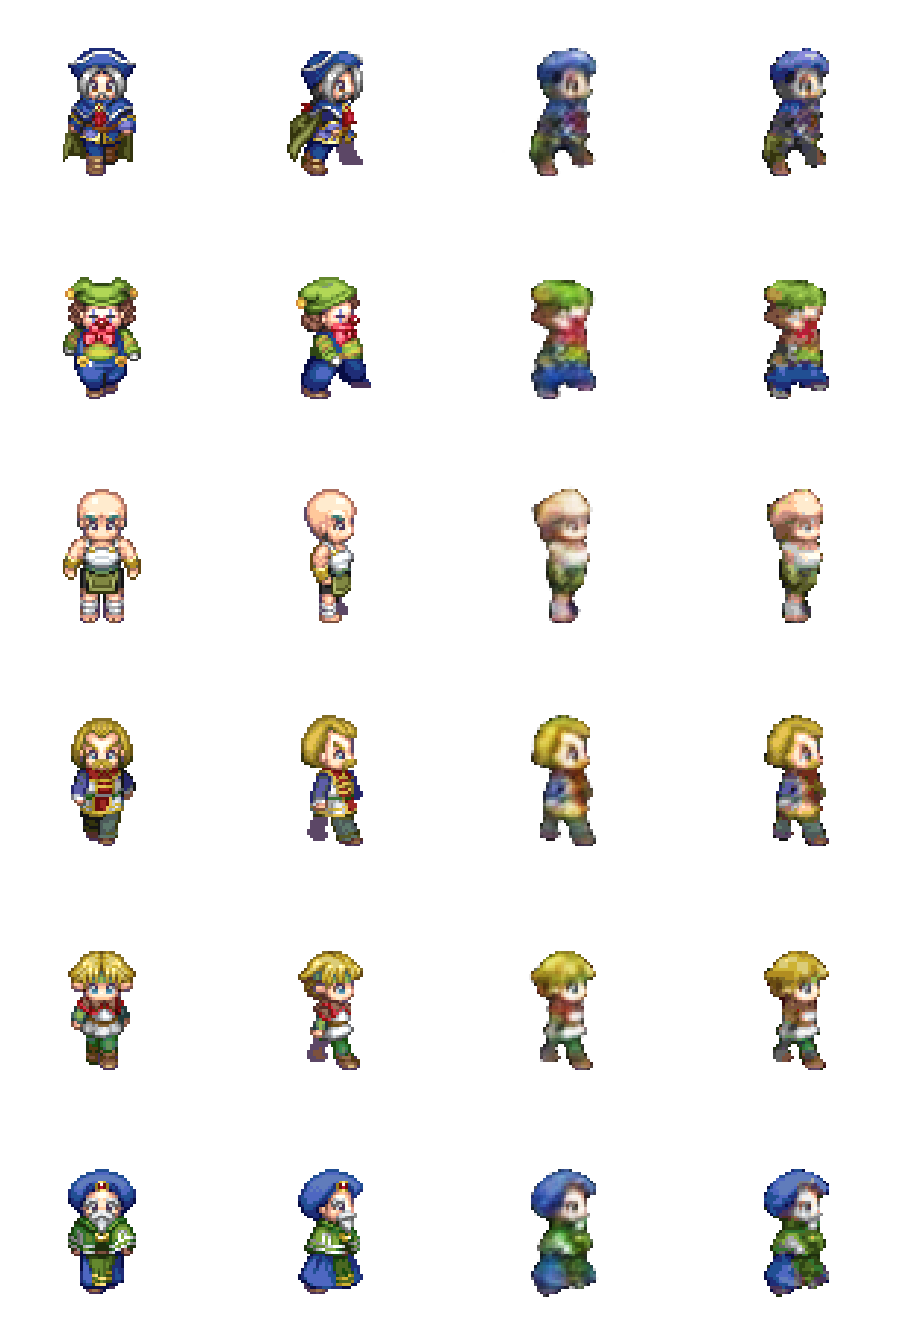

Showing images from model index 2


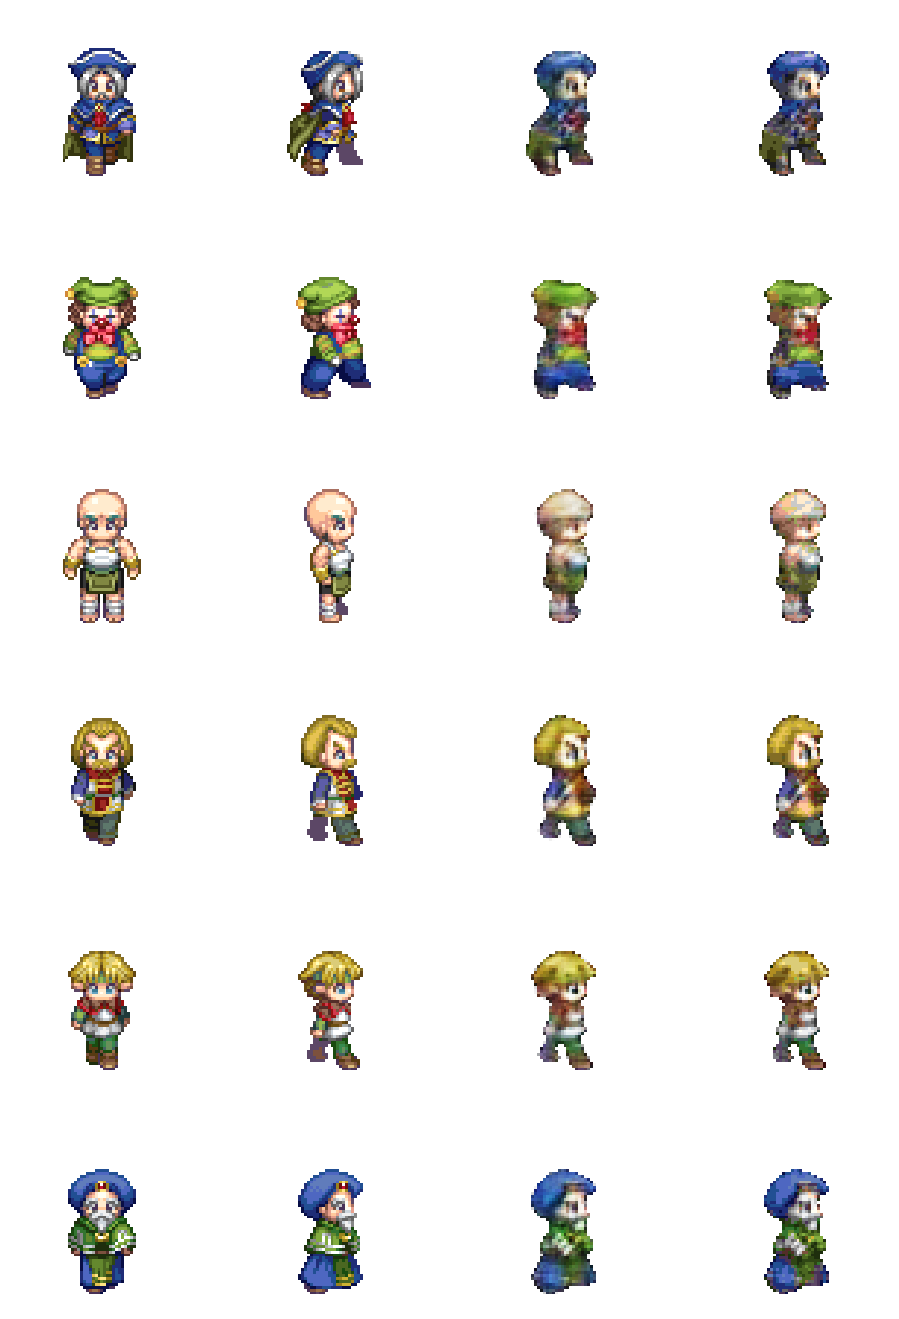

In [3]:
import io_utils
from matplotlib import pyplot as plt

def generate_comparison(model, examples):
    column_titles = ["Source", "Target", "Generated", "Adjusted"]
    num_columns = len(column_titles)
    num_rows = len(examples)

    plt.figure(figsize=(4 * num_columns, 4 * num_rows))
    for row, (source_image, target_image) in enumerate(examples):
        predicted_image = model.generator(source_image, training=True)
        palette = io_utils.extract_palette(source_image, fill_until_size=None, resulting_image_type="float32").numpy()
        # print("palette", palette)
        palette_adjusted_predicted_image = palette_transform(predicted_image.numpy(), palette)
        images = [source_image, target_image, predicted_image, palette_adjusted_predicted_image]
        for col in range(num_columns):
            idx = row * num_columns + col + 1
            plt.subplot(num_rows, num_columns, idx)
            plt.title(column_titles[col] if i == 0 else "", fontdict={"fontsize": 24})
            plt.imshow(images[col][0] * 0.5 + 0.5, interpolation="nearest")
            plt.axis("off")

    plt.show()

examples = models[0].select_examples_for_visualization(num_examples=6)
for i, model in enumerate(models):
    print(f"Showing images from model index {i}")
    generate_comparison(model, examples)

    # image_data = model.generate_comparison(examples)
    # io_utils.plot_to_image(image_data)
    # images = models[0].generator(next(iter(models[0].test_ds.unbatch().take(5).batch())), training=True)